<a href="https://colab.research.google.com/github/HyeonhoonLee/kaggle/blob/main/282_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
os.chdir('/content/drive/MyDrive/Kaggle/')

In [12]:
# os.getcwd()

In [2]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeonhoonlee","key":"f9cee1679e1bf0a66eaa224629645fc6"}'}

In [13]:
# !mkdir -p /content/drive/MyDrive/Kaggle/.kaggle
# !mv kaggle.json /content/drive/MyDrive/Kaggle/.kaggle/
# !chmod 600 /content/drive/MyDrive/Kaggle/.kaggle/kaggle.json

In [14]:
# !kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:27<00:00, 29.8MB/s]
100% 5.76G/5.76G [02:28<00:00, 41.8MB/s]


In [15]:
# ls

cassava-leaf-disease-classification.zip


In [ ]:
# !unzip /content/drive/MyDrive/Kaggle/cassava-leaf-disease-classification.zip

# library import

In [17]:
import numpy as np 
import pandas as pd 
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.optimizers import Adam

# Data preprocessing

In [19]:
training_folder = '/content/drive/MyDrive/Kaggle/train_images/' #훈련할 이미지들이 있는 폴더
samples_df = pd.read_csv('/content/drive/MyDrive/Kaggle/train.csv') #훈련할 이미지의 이름 및 각 label 데이터 로드
samples_df["filepath"] = training_folder+samples_df["image_id"] #사진을 불러오기 쉽도록 폴더와 이미지의 이름을 합쳐 경로를 생성
samples_df = samples_df.drop(['image_id'],axis=1) #필요없는 이미지 이름을 모두 버림

In [20]:
samples_df.head()

,label,filepath
0,0,/content/drive/MyDrive/Kaggle/train_images/100...
1,3,/content/drive/MyDrive/Kaggle/train_images/100...
2,1,/content/drive/MyDrive/Kaggle/train_images/100...
3,1,/content/drive/MyDrive/Kaggle/train_images/100...
4,3,/content/drive/MyDrive/Kaggle/train_images/100...


In [44]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21397 entries, 9134 to 15795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     21397 non-null  int64 
 1   filepath  21397 non-null  object
dtypes: int64(1), object(1)
memory usage: 501.5+ KB


In [21]:
samples_df = shuffle(samples_df, random_state=42) #데이터를 무작위로 섞음
train_size = int(len(samples_df)*0.8) # 훈련에 사용할 데이터의 크기를 지정
training_df = samples_df[:train_size] # 훈련 데이터셋을 만들어줌
validation_df = samples_df[train_size:] # validation 데이터셋을 만들어줌

In [22]:
training_df.head()

,label,filepath
9134,4,/content/drive/MyDrive/Kaggle/train_images/261...
1580,3,/content/drive/MyDrive/Kaggle/train_images/127...
7304,3,/content/drive/MyDrive/Kaggle/train_images/230...
13196,2,/content/drive/MyDrive/Kaggle/train_images/336...
5333,2,/content/drive/MyDrive/Kaggle/train_images/195...


In [23]:
validation_df.head()

,label,filepath
10234,3,/content/drive/MyDrive/Kaggle/train_images/282...
4763,3,/content/drive/MyDrive/Kaggle/train_images/184...
9062,3,/content/drive/MyDrive/Kaggle/train_images/260...
1874,3,/content/drive/MyDrive/Kaggle/train_images/133...
17431,3,/content/drive/MyDrive/Kaggle/train_images/414...


In [64]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    training_df, 
    directory='/content/drive/MyDrive/Kaggle/train_images', 
    x_col='filepath', y_col='label',
    weight_col=None, target_size=(256,256), color_mode='rgb', class_mode='raw', batch_size=32)
validation_generator = test_datagen.flow_from_dataframe(
    validation_df, 
    directory='/content/drive/MyDrive/Kaggle/train_images', 
    x_col='filepath', y_col='label',
    weight_col=None, target_size=(256,256), color_mode='rgb', class_mode='raw', batch_size=32)

Found 17117 validated image filenames.
Found 4280 validated image filenames.


# image를 dataset으로 만들기

In [24]:
batch_size = 8 # 배치 사이즈를 설정
image_size = 512 # 이미지의 크기를 설정
input_shape = (image_size, image_size, 3) #이미지의 사이즈 정의 (컬러 이미지이기 때문에 한 화소당 3개의 데이터가 필요)
dropout_rate = 0.1 #드롭아웃 비율 정의
classes_to_predict = sorted(training_df.label.unique()) #예측해야 하는 클래스 수 정의, 여기서는 5개

In [25]:
"""
train 데이터와 validation 데이터를 텐서플로우 Dataset으로 정의합니다.
텐서플로우 Dataset는 동적으로 데이터를 불러와, 너무 많은 데이터가 메모리에 쓰여지는 일을 방지하여 퍼포먼스가 향상됩니다.
더 자세한 내용은 아래의 링크를 참조하세요.
https://www.tensorflow.org/guide/data_performance?hl=ko
"""
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [26]:
def load_image_and_label_from_path(image_path, label): #이미지 데이터를 불러와 텐서 (array와 비슷한 형태)로 변환하는 함수
    img = tf.io.read_file(image_path) #이미지 경로의 파일을 읽음
    img = tf.image.decode_jpeg(img, channels=3) #이미지를 array 데이터로 변환하여 저장
    img = tf.image.random_crop(img, size=[image_size,image_size,3]) # 이미지를 랜덤으로 원하는 사이즈로 잘라줌. 중앙만 자르고 싶다면 central_crop 사용.
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE #메모리 동적 할당을 위한 AUTOTUNE
training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE) #train 데이터를 불러옴
validation_data = validation_data.map(load_image_and_label_from_path,num_parallel_calls=AUTOTUNE) #validation 데이터를 불러옴

In [27]:
#train 및 validation 데이터를 훈련하기 좋게 batch로 자름
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# ViT Model
- Reference github: https://github.com/emla2805/vision-transformer

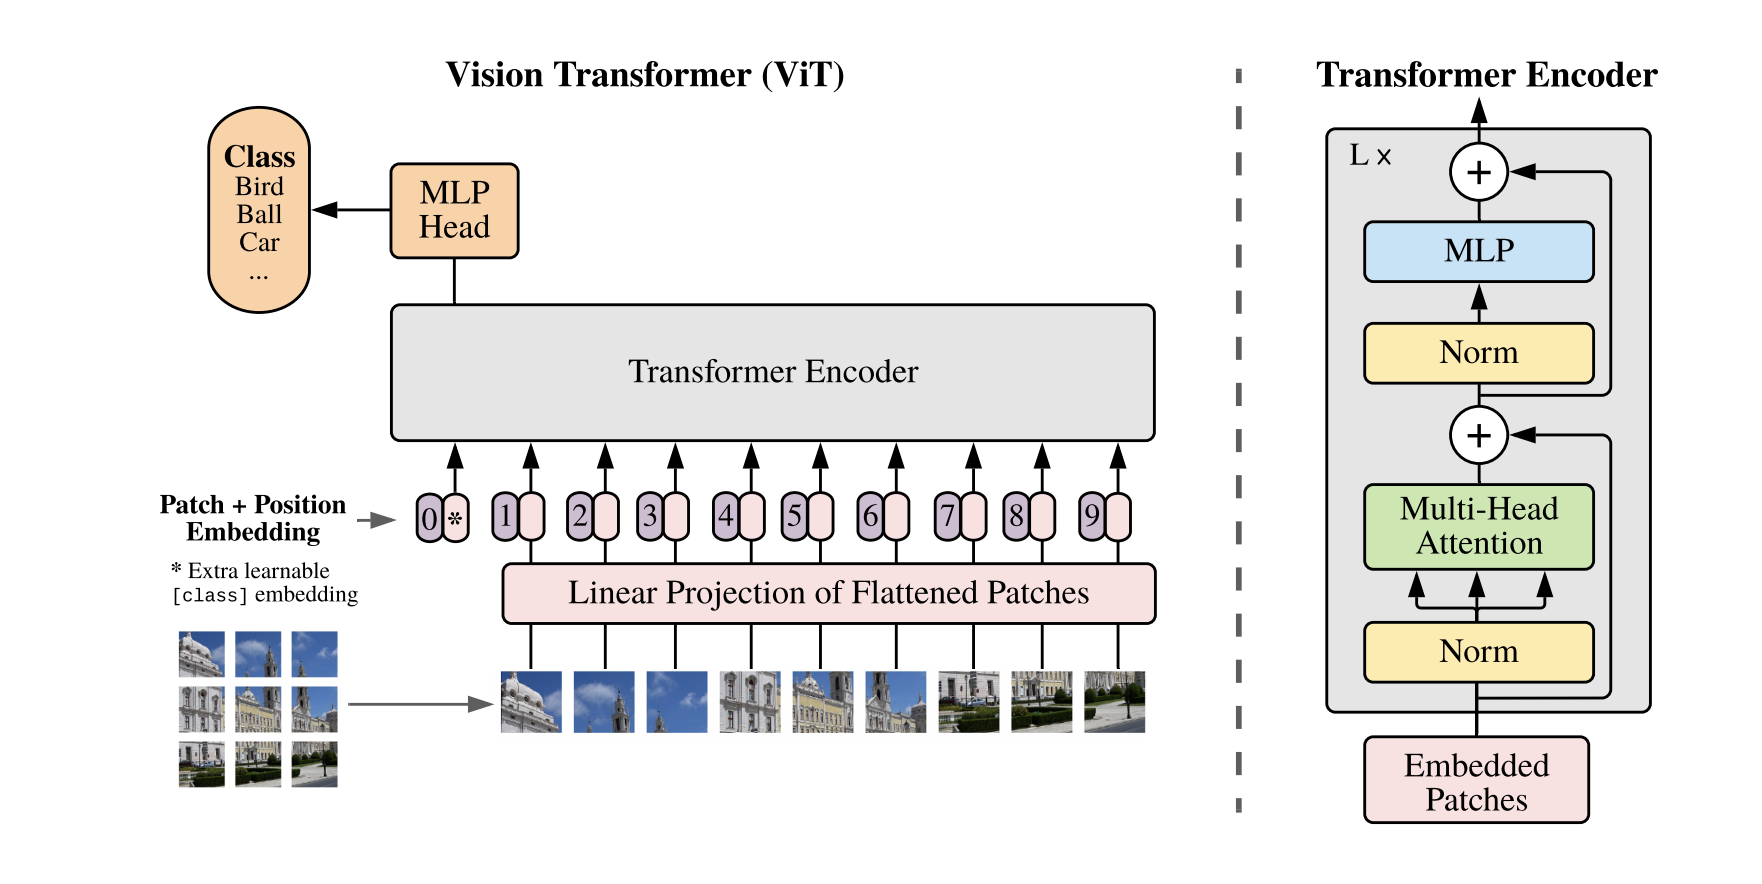

In [28]:
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        output = self.combine_heads(concat_attention)
        return output


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tf.keras.activations.gelu),
                Dropout(dropout),
                Dense(embed_dim),
                Dropout(dropout),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        return mlp_output + out1


class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        image_size,
        patch_size,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        channels=3,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.d_model = d_model
        self.num_layers = num_layers

        self.rescale = Rescaling(1.0 / 255)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model)
        )
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        self.patch_proj = Dense(d_model)
        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(mlp_dim, activation=tf.keras.activations.gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        x = self.rescale(x)
        patches = self.extract_patches(x)
        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training)

        # First (class token) is used for classification
        x = self.mlp_head(x[:, 0])
        return x

In [78]:
model = VisionTransformer(
            image_size=512,
            patch_size=64,
            num_layers=4,
            num_classes=5,
            d_model=1024,
            num_heads=4,
            mlp_dim=128,
            channels=3,
            dropout=0.1,
        )

# 모델 학습

In [79]:
epochs = 30 #에폭 수를 설정합니다.
# decay_steps = int(round(len(training_df)/batch_size))*epochs
# cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3) 
#learning rate를 에폭이 지날수록 점점 줄여나가는 cosine decay 방법을 사용합니다. 
callbacks = [ModelCheckpoint(filepath='./mymodel.h5', monitor='val_loss', save_best_only=True), 
             #가장 validation loss가 낮은 에폭의 모델을 .h5 파일로 저장합니다. 
            EarlyStopping(monitor='val_loss', patience = 5, verbose=1)] 
            #정해진 에폭이 되기 전에 5번의 에폭동한 validation loss가 향상되지 않으면 학습을 종료합니다. 

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True), optimizer='Adam', metrics=["accuracy"]) 
#loss는 sparse_categorical_crossentropy, optimizer는 Adam을 사용합니다. 각 에폭당 정확도를 통해 모델의 성능을 모니터링합니

In [ ]:
history = model.fit(train_generator, #모델을 학습합니다. 
                  epochs = epochs, 
                  validation_data=validation_generator,
                  callbacks=callbacks)

Epoch 1/30
535/535 [==============================] - 1232s 2s/step - loss: 1.3864 - accuracy: 0.5938 - val_loss: 1.1876 - val_accuracy: 0.6133
Epoch 2/30
535/535 [==============================] - 555s 1s/step - loss: 1.2049 - accuracy: 0.6133 - val_loss: 1.1972 - val_accuracy: 0.6133
Epoch 3/30
535/535 [==============================] - ETA: 0s - loss: 1.1971 - accuracy: 0.6171

In [74]:
model.save_weights('/content/drive/MyDrive/Kaggle/model.h5')